## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Business Understanding

## Data Understanding

## Business Problem

### Import Packages

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

In [201]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally
pd.set_option('display.max_columns', None)

# Converts from scientific notation to standard form (applied to every df in
# this notebook) and rounds to two decimal places
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Data Exploration and  Preparation

In [202]:
df = pd.read_csv('data/kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0000,3,1.0000,1180,5650,1.0000,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0000,98178,47.5112,-122.2570,1340,5650
1,6414100192,12/9/2014,538000.0000,3,2.2500,2570,7242,2.0000,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0000,98125,47.7210,-122.3190,1690,7639
2,5631500400,2/25/2015,180000.0000,2,1.0000,770,10000,1.0000,NO,NONE,Average,6 Low Average,770,0.0,1933,nan,98028,47.7379,-122.2330,2720,8062
3,2487200875,12/9/2014,604000.0000,4,3.0000,1960,5000,1.0000,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0000,98136,47.5208,-122.3930,1360,5000
4,1954400510,2/18/2015,510000.0000,3,2.0000,1680,8080,1.0000,NO,NONE,Average,8 Good,1680,0.0,1987,0.0000,98074,47.6168,-122.0450,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0000,3,2.5000,1530,1131,3.0000,NO,NONE,Average,8 Good,1530,0.0,2009,0.0000,98103,47.6993,-122.3460,1530,1509
21593,6600060120,2/23/2015,400000.0000,4,2.5000,2310,5813,2.0000,NO,NONE,Average,8 Good,2310,0.0,2014,0.0000,98146,47.5107,-122.3620,1830,7200
21594,1523300141,6/23/2014,402101.0000,2,0.7500,1020,1350,2.0000,NO,NONE,Average,7 Average,1020,0.0,2009,0.0000,98144,47.5944,-122.2990,1020,2007
21595,291310100,1/16/2015,400000.0000,3,2.5000,1600,2388,2.0000,NaN,NONE,Average,8 Good,1600,0.0,2004,0.0000,98027,47.5345,-122.0690,1410,1287


<AxesSubplot:xlabel='price'>

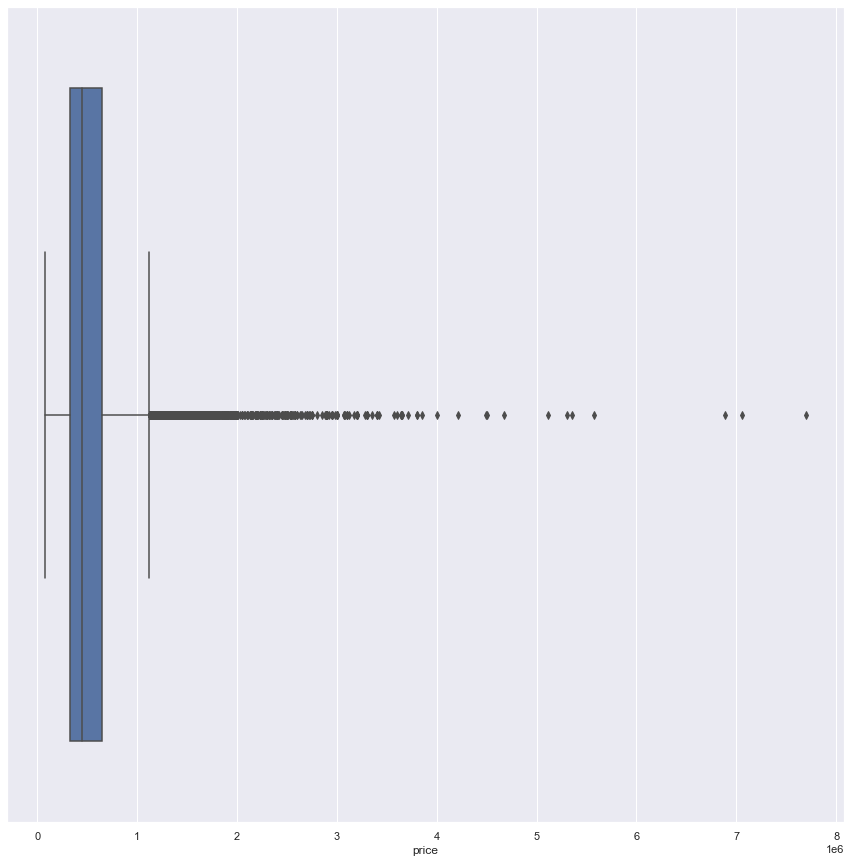

In [203]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.boxplot(x= df["price"])

In [204]:
# make a copy and clean the data for modeling 
df_copy = df.copy()
df_copy = df_copy.drop_duplicates(subset= ['id'], keep = "last")
df_copy['grade'] = df_copy["grade"].str.split(" ").str[0].astype('int64')
df_copy = df_copy.loc[(df_copy['grade'] != 13) & (df_copy['grade'] != 3) & (df_copy["grade"] != 4)]
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Poor", '1'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Fair", '2'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Average", '3'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Very Good", '5'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Good", '4'))
df_copy['condition'] = df_copy["condition"].astype("int64")
df_copy = df_copy.drop(['sqft_basement', 'yr_renovated', 'id', 'date', 'waterfront', 'view'], axis=1)

q3, q1 = np.percentile(df_copy['price'], [75, 25])
q3, q1
iqr = q3-q1
lower_limit = df_copy['price'].mean() - (iqr*1.5)
upper_limit = df_copy['price'].mean() + (iqr*1.5)
lower_limit, upper_limit

df_copy = df_copy[df_copy['price'] < upper_limit]

In [205]:
training_data = df_copy.sample(frac = 0.75, random_state=25)
x_train = training_data.drop('price', axis=1)
y_train = training_data['price']

testing_data = df_copy.drop(training_data.index)
x_test = testing_data.drop('price', axis =1)
y_test = testing_data['price']

## Model Construction

### Build a baseline Model

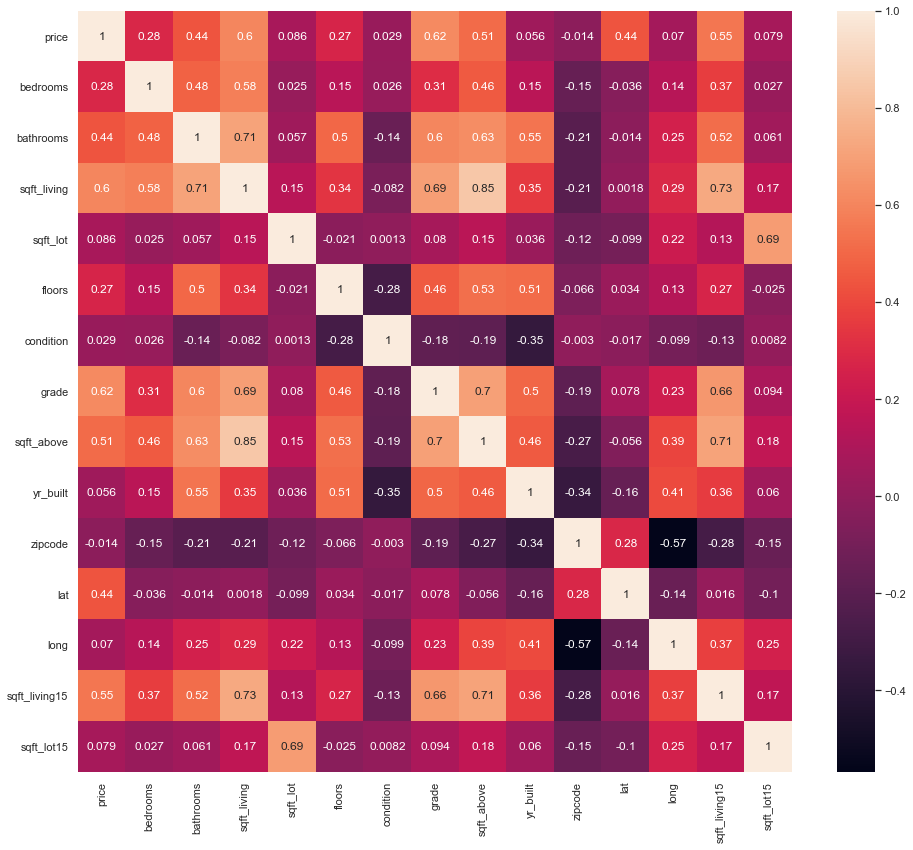

In [206]:
heatmap_data = pd.concat([y_train, x_train], axis=1)
corr = heatmap_data.corr()
sns.set(rc={'figure.figsize':(16, 14)})
sns.heatmap(data=corr, annot=True);

In [207]:
price_corrs = heatmap_data.corr()['price'].map(abs).sort_values(ascending=False)
price_corrs

price           1.0000
grade           0.6188
sqft_living     0.6046
sqft_living15   0.5495
sqft_above      0.5145
bathrooms       0.4403
lat             0.4379
bedrooms        0.2831
floors          0.2701
sqft_lot        0.0861
sqft_lot15      0.0791
long            0.0697
yr_built        0.0558
condition       0.0293
zipcode         0.0139
Name: price, dtype: float64

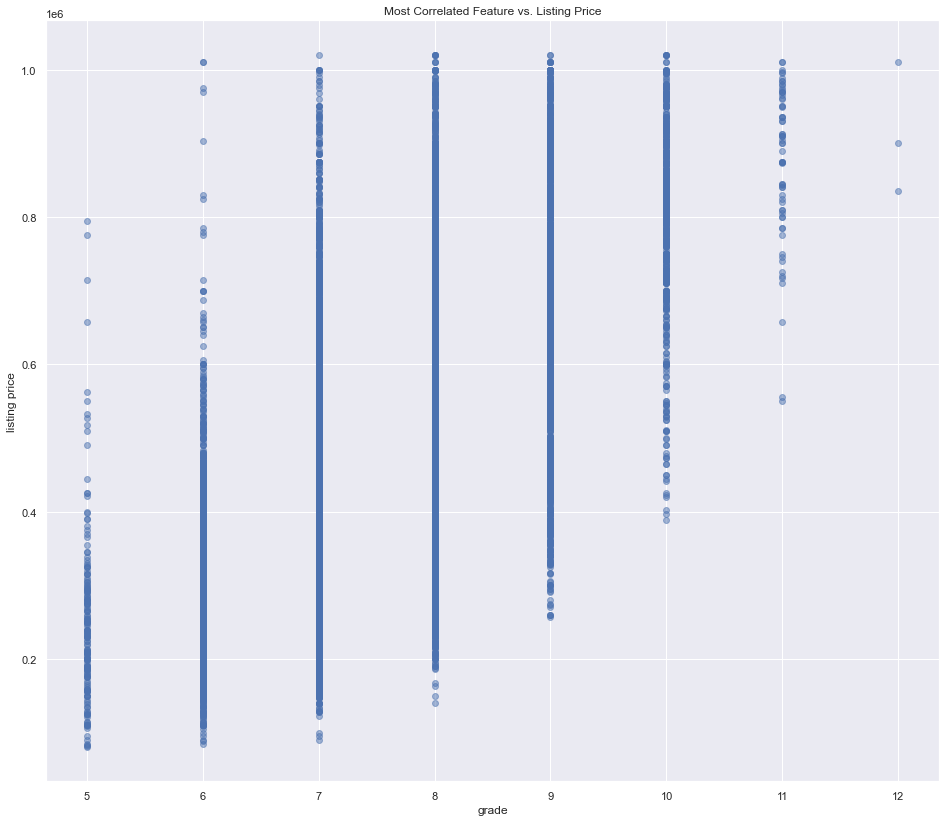

In [208]:
most_correlated_feature = "grade"

fig, ax = plt.subplots()
ax.scatter(x_train[most_correlated_feature], y_train, alpha=0.5)
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("listing price")
ax.set_title("Most Correlated Feature vs. Listing Price");

In [209]:
baseline_model = LinearRegression()

In [210]:
from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.75, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=x_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

baseline_model = LinearRegression()

# Fit the model on X_train_final and y_train
baseline_model = baseline_model.fit(x_train[[most_correlated_feature]], y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
print("The test score is: ", baseline_model.score(x_test[[most_correlated_feature]], y_test))


Train score:      0.3854925641762302
Validation score: 0.381568978173713
The test score is:  0.37166733804450325


#### Assumption Tests

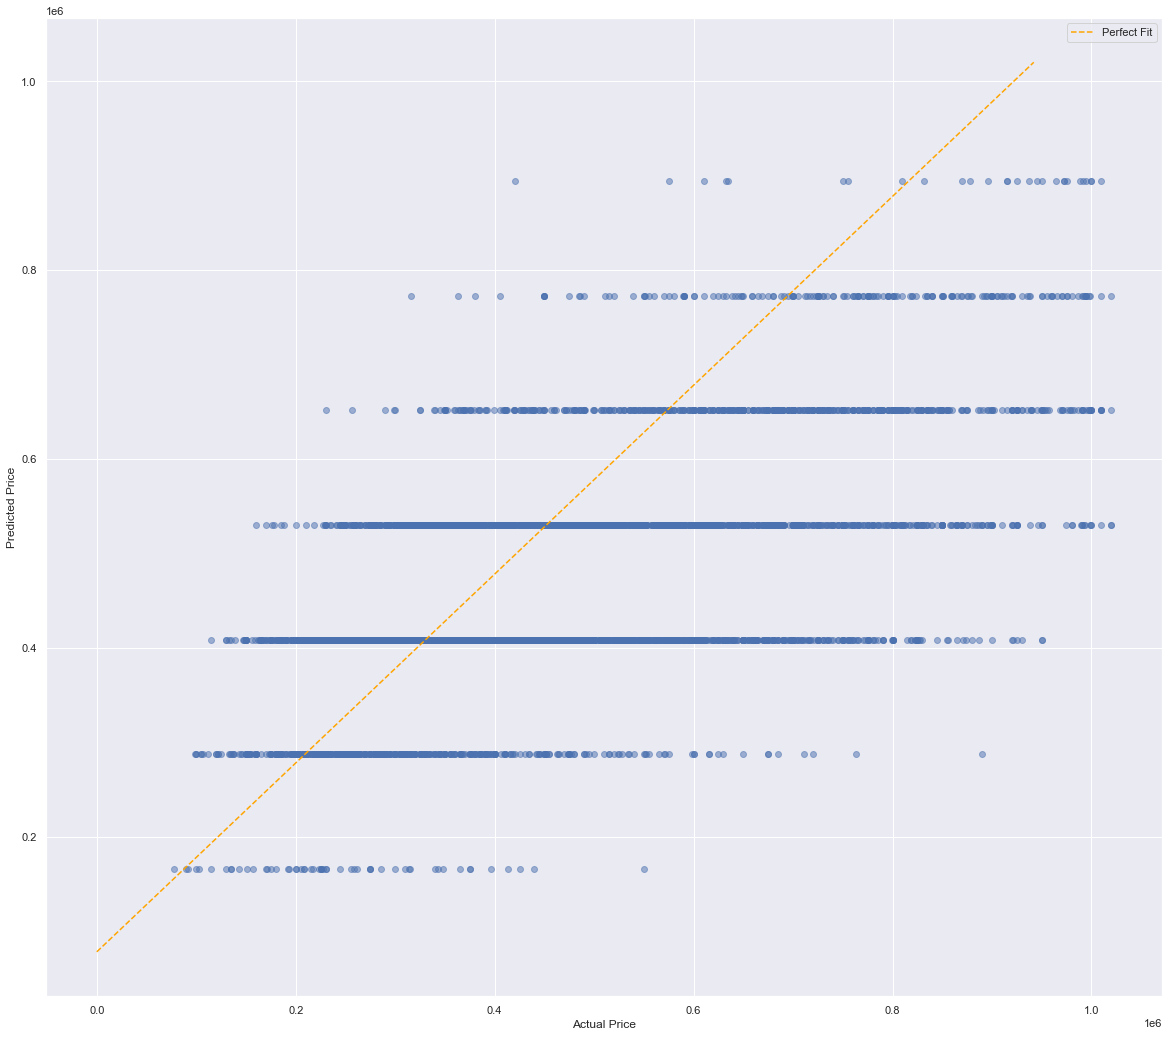

In [211]:
preds = baseline_model.predict(x_test[[most_correlated_feature]])
fig, ax = plt.subplots(figsize=(20, 18))

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
# ax.set_facecolor("white")a
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

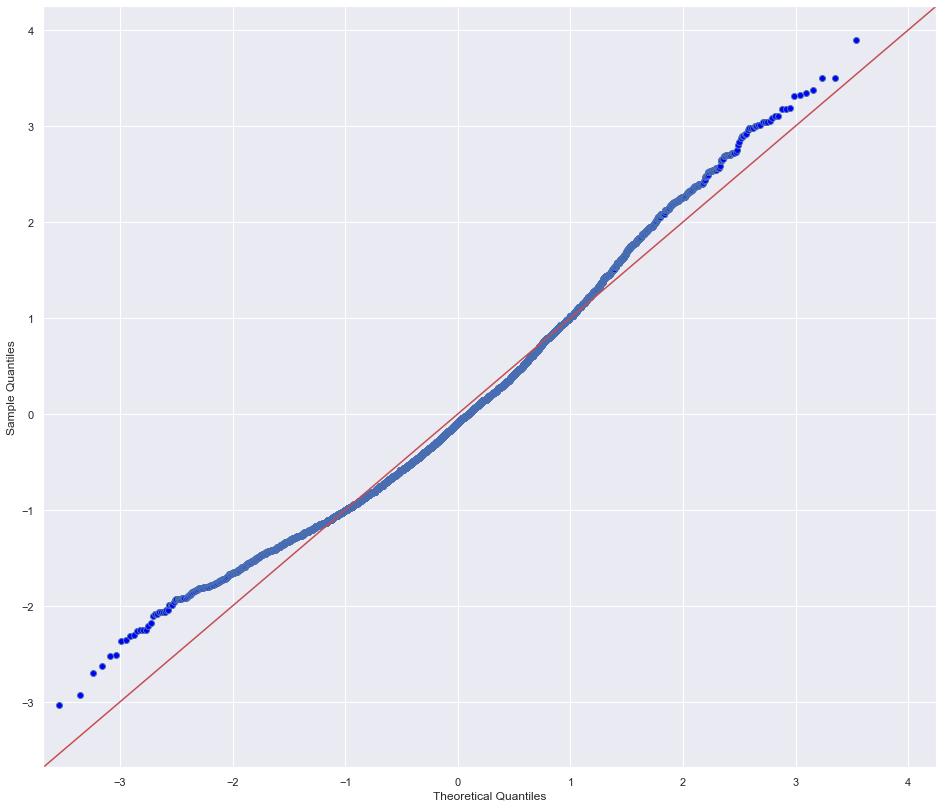

In [213]:
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

## Outliers violating normality

ValueError: x and y must have same first dimension, but have shapes (4995,) and (19981,)

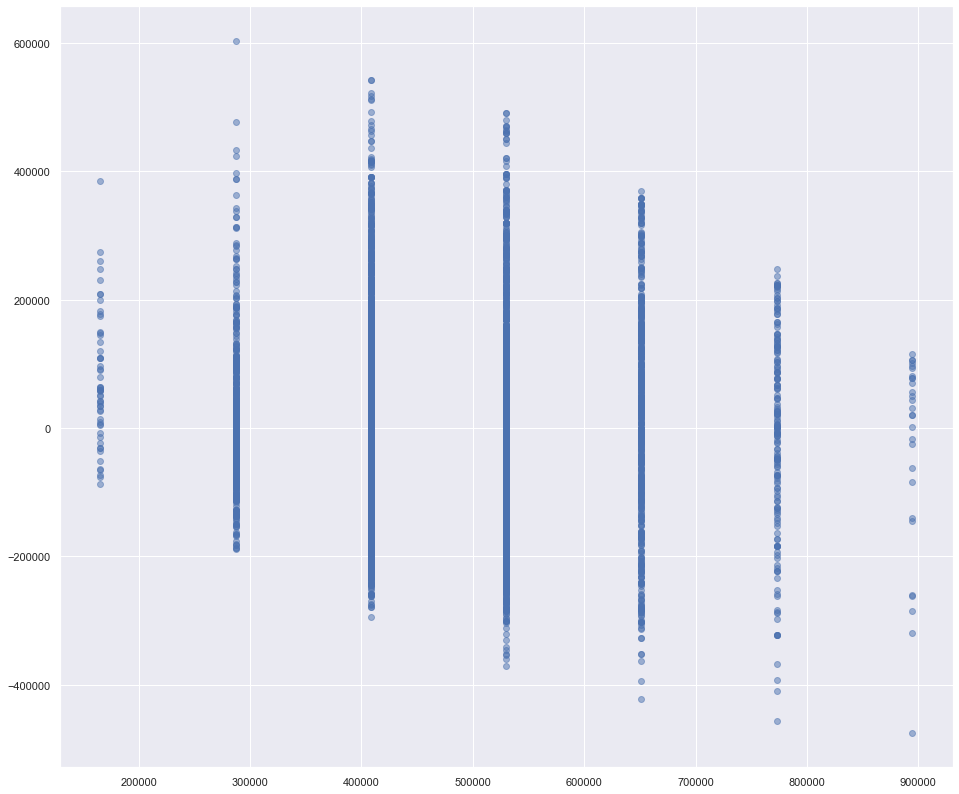

In [214]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

## violating homoscedasticity

In [155]:
x_train_numeric = x_train.copy()
x_train_numeric

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
13434,4,1.7500,1880,3720,1.5000,4,7,1880,1924,98109,47.6431,-122.3560,2090,4095
985,4,2.7500,2130,8560,1.0000,3,7,1560,1992,98022,47.1949,-122.0100,2130,8560
3993,4,1.7500,2530,5000,1.5000,5,8,2070,1917,98103,47.6624,-122.3480,1950,3600
10377,4,2.5000,2390,9638,2.0000,3,10,2390,1988,98029,47.5598,-122.0180,2630,9258
847,3,1.7500,4000,11894,1.0000,3,9,2190,1987,98011,47.7738,-122.2030,2530,8650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14381,2,2.0000,1730,4248,2.0000,3,7,1730,1905,98144,47.5933,-122.3080,1380,4000
9093,4,2.5000,2540,6365,2.0000,3,8,1870,2000,98055,47.4608,-122.2150,2290,5942
14099,2,1.0000,1030,4365,1.0000,3,7,1030,1942,98117,47.6875,-122.3870,1420,4268
13858,3,2.5000,1690,1553,2.5000,3,8,1690,2007,98199,47.6443,-122.3850,1910,1553


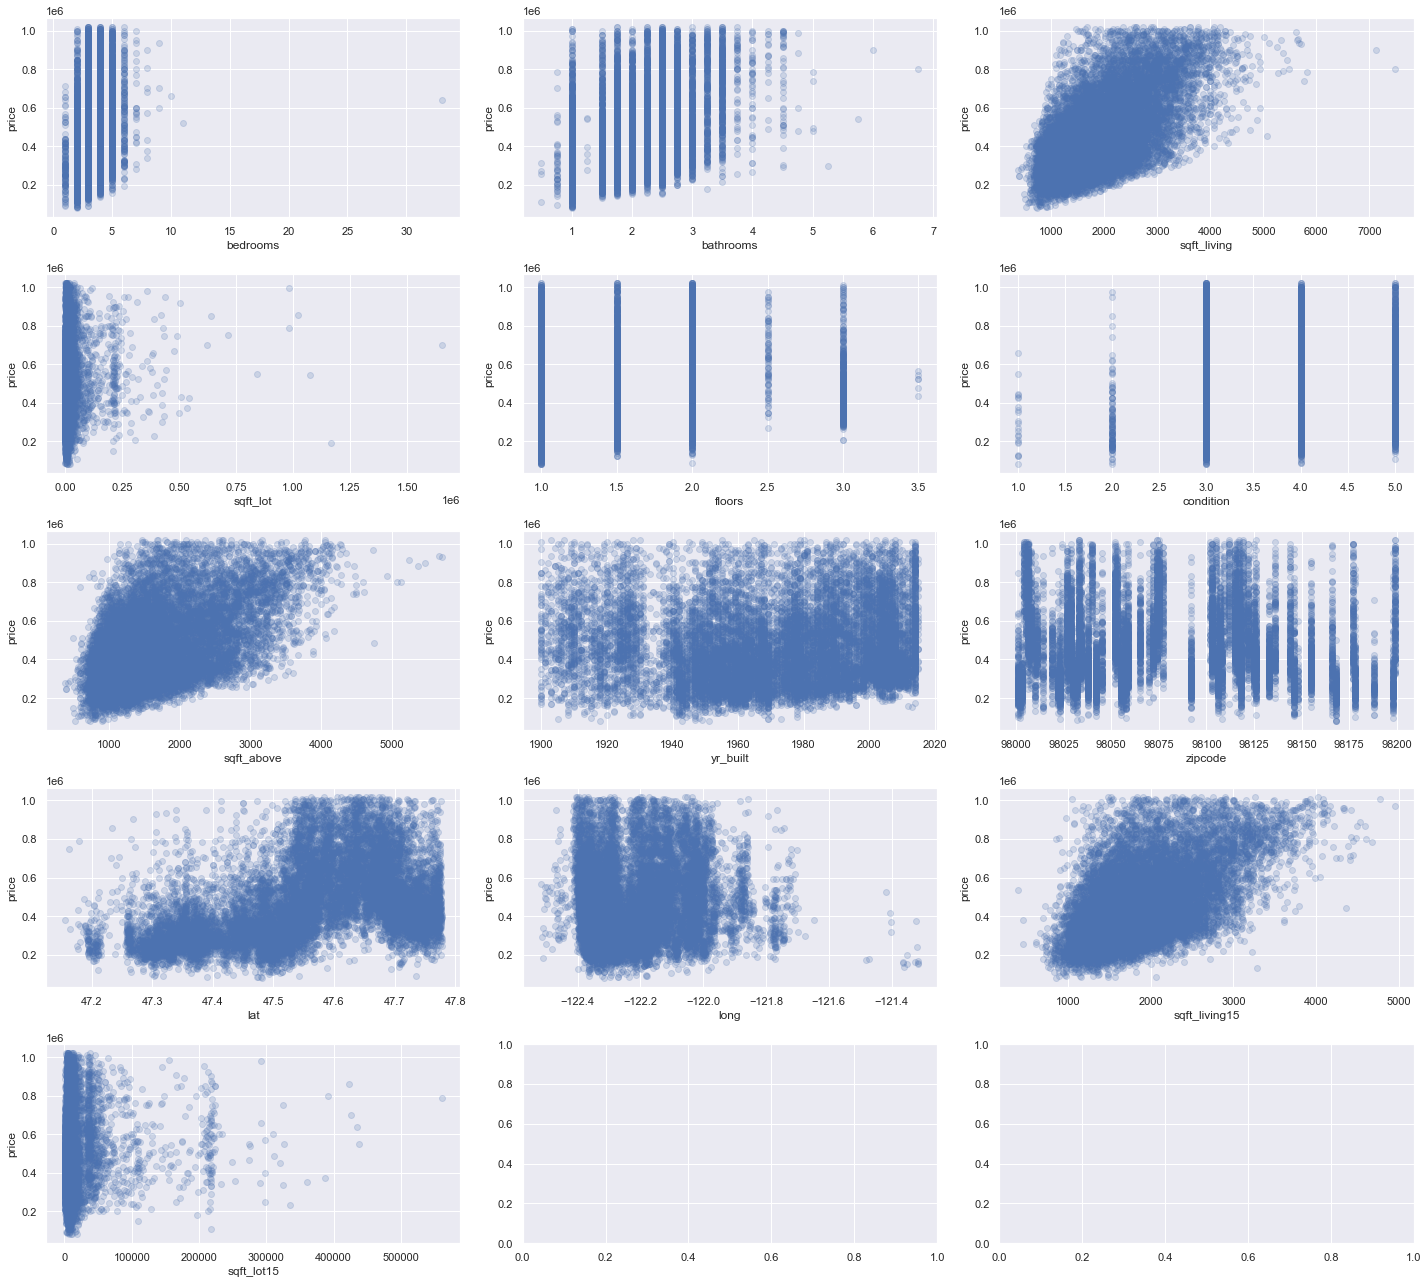

In [156]:
scatterplot_data = x_train_numeric.drop("grade", axis=1)

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(20, 18))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//3][index%3]
    ax.scatter(x_train_numeric[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("price")

### Run the second model

In [157]:
# based on heatmap, we dropped variables that have correlation over 0.7 with another independent variables to minimize 
# multicollinearity. 

x_train_second_model = x_train_numeric.drop('bathrooms', axis=1).copy()
x_train_second_model = x_train_second_model.drop('sqft_living15', axis=1).copy()
x_train_second_model = x_train_second_model.drop('sqft_above', axis=1).copy()
x_train_second_model

,bedrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,lat,long,sqft_lot15
13434,4,1880,3720,1.5000,4,7,1924,98109,47.6431,-122.3560,4095
985,4,2130,8560,1.0000,3,7,1992,98022,47.1949,-122.0100,8560
3993,4,2530,5000,1.5000,5,8,1917,98103,47.6624,-122.3480,3600
10377,4,2390,9638,2.0000,3,10,1988,98029,47.5598,-122.0180,9258
847,3,4000,11894,1.0000,3,9,1987,98011,47.7738,-122.2030,8650
...,...,...,...,...,...,...,...,...,...,...,...
14381,2,1730,4248,2.0000,3,7,1905,98144,47.5933,-122.3080,4000
9093,4,2540,6365,2.0000,3,8,2000,98055,47.4608,-122.2150,5942
14099,2,1030,4365,1.0000,3,7,1942,98117,47.6875,-122.3870,4268
13858,3,1690,1553,2.5000,3,8,2007,98199,47.6443,-122.3850,1553


In [158]:
second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=x_train_second_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6693512695470417
Validation score: 0.6643748022712099

Baseline Model
Train score:      0.3854925641762302
Validation score: 0.381568978173713


### Select the Best Combinations of Features

In [159]:
sm.OLS(y_train, sm.add_constant(x_train_second_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     2728.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        23:56:50   Log-Likelihood:            -1.9577e+05
No. Observations:               14986   AIC:                         3.916e+05
Df Residuals:                   14974   BIC:                         3.917e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.437e+06   1.92e+06     -3.361      0.001   -1.02e+07   -2.68e+06
bedrooms    -8925.0956   1281.490     -6.965      0.000   -1.14e+04   -6413.219
sqft_living   102.0327      2.070     49.295      0.000      97.976     106.090
sqft_lot        0.2057      0.031      6.635      0.000       0.145       0.266
floors       3.446e+04   2150.702     16.024      0.000    3.02e+04    3.87e+04
condition    2.407e+04   1570.391     15.329      0.000     2.1e+04    2.72e+04
grade        8.303e+04   1443.421     57.524      0.000    8.02e+04    8.59e+04
yr_built    -1748.0985     45.445    -38.466      0.000   -1837.177   -1659.020
zipcode      -195.7649     22.343     -8.762      0.000    -239.559    -151.971
lat          5.252e+05   7055.513     74.432      0.000    5.11e+05    5.39e+05
long        -2.985e+04   8567.356     -3.485      0.000   -4.66e+04   -1.31e+04
sqft_lot15     -0.0185      0.050     -0.368      0.713      -0.117       0.080
==============================================================================
Omnibus:                     1146.033   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1878.548
Skew:                           0.585   Prob(JB):                         0.00
Kurtosis:                       4.280   Cond. No.                     2.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Run the Third Model

In [160]:
# drop p-value > 0.05, so sqft_lot15 will be dropped.

significant_features = ['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 
                        'condition', 'grade', 'yr_built', 'zipcode', 'lat', 'long'] 


# x_train_third_model = x_train_second_model.drop(['sqft_above', 'sqft_lot15'], axis=1).copy()
# x_train_third_model

In [161]:
third_model = LinearRegression()
x_train_third_model = x_train[significant_features]

third_model_scores = cross_validate(
    estimator=third_model,
    X=x_train_third_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())
print()
print("Second Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6691562834412729
Validation score: 0.6646815390133285

Second Model
Train score:      0.6693512695470417
Validation score: 0.6643748022712099

Baseline Model
Train score:      0.3854925641762302
Validation score: 0.381568978173713


### RFE approach

In [162]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
x_train_for_RFECV = StandardScaler().fit_transform(x_train_third_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(x_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(x_train_third_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
sqft_living: True
sqft_lot: True
floors: True
condition: True
grade: True
yr_built: True
zipcode: True
lat: True
long: True


In [168]:
best_features = significant_features
x_train_final = x_train[best_features]
x_test_final = x_test[best_features]

final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model = final_model.fit(x_train_final, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
print("The test score is: ", final_model.score(x_test_final, y_test))
print("The RMSE for the test is: ", mean_squared_error(y_test, final_model.predict(x_test_final), squared=False))

The test score is:  0.6717980155783607
The RMSE for the test is:  112243.7457638945


In [169]:
sm.OLS(y_train, sm.add_constant(x_train_third_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     3001.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        00:01:40   Log-Likelihood:            -1.9577e+05
No. Observations:               14986   AIC:                         3.916e+05
Df Residuals:                   14975   BIC:                         3.917e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.478e+06   1.91e+06     -3.388      0.001   -1.02e+07   -2.73e+06
bedrooms    -8896.8970   1279.161     -6.955      0.000   -1.14e+04   -6389.585
sqft_living   101.9685      2.062     49.441      0.000      97.926     106.011
sqft_lot        0.1982      0.023      8.485      0.000       0.152       0.244
floors        3.45e+04   2148.400     16.058      0.000    3.03e+04    3.87e+04
condition    2.406e+04   1570.156     15.326      0.000     2.1e+04    2.71e+04
grade        8.304e+04   1443.325     57.531      0.000    8.02e+04    8.59e+04
yr_built    -1748.0459     45.444    -38.466      0.000   -1837.121   -1658.970
zipcode      -195.8071     22.342     -8.764      0.000    -239.599    -152.015
lat          5.252e+05   7051.005     74.493      0.000    5.11e+05    5.39e+05
long        -3.018e+04   8520.095     -3.543      0.000   -4.69e+04   -1.35e+04
==============================================================================
Omnibus:                     1145.889   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1877.998
Skew:                           0.585   Prob(JB):                         0.00
Kurtosis:                       4.279   Cond. No.                     2.04e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [132]:
print(pd.Series(final_model.coef_, index=x_train_final.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

bedrooms       -8896.8970
sqft_living      101.9685
sqft_lot           0.1982
floors         34498.7206
condition      24063.6969
grade          83035.5763
yr_built       -1748.0459
zipcode         -195.8071
lat           525249.1128
long          -30184.4161
Name: Coefficients, dtype: float64

Intercept: -6477958.174080452


### Apply One Hot Encoder to Zipcode

In [133]:
df_test = df_copy.copy()

In [134]:
df_test

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0000,3,1.0000,1180,5650,1.0000,3,7,1180,1955,98178,47.5112,-122.2570,1340,5650
1,538000.0000,3,2.2500,2570,7242,2.0000,3,7,2170,1951,98125,47.7210,-122.3190,1690,7639
2,180000.0000,2,1.0000,770,10000,1.0000,3,6,770,1933,98028,47.7379,-122.2330,2720,8062
3,604000.0000,4,3.0000,1960,5000,1.0000,5,7,1050,1965,98136,47.5208,-122.3930,1360,5000
4,510000.0000,3,2.0000,1680,8080,1.0000,3,8,1680,1987,98074,47.6168,-122.0450,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0000,3,2.5000,1530,1131,3.0000,3,8,1530,2009,98103,47.6993,-122.3460,1530,1509
21593,400000.0000,4,2.5000,2310,5813,2.0000,3,8,2310,2014,98146,47.5107,-122.3620,1830,7200
21594,402101.0000,2,0.7500,1020,1350,2.0000,3,7,1020,2009,98144,47.5944,-122.2990,1020,2007
21595,400000.0000,3,2.5000,1600,2388,2.0000,3,8,1600,2004,98027,47.5345,-122.0690,1410,1287


In [135]:
df_test = df_test.reset_index()
encoder = OneHotEncoder()
# apply on df
# color_1hot = encoder.fit_transform(df_clean["zipcode"].values.reshape(-1,1))
# color_1hot_df = pd.DataFrame(color_1hot.toarray())
# df_clean = pd.concat([df_clean.drop('zipcode', axis = 1), color_1hot_df], axis = 1)
zipcode_trans = encoder.fit_transform(df_test['zipcode'].values.reshape(-1,1))
zipcode_trans.todense()
encoder.get_feature_names()
zipcode_df =pd.DataFrame(zipcode_trans.todense(), columns = encoder.get_feature_names())
zipcode_df
df_test = df_test.join(zipcode_df)

endog = df_test["price"]
exog = sm.add_constant(df_test.drop(['price', 'zipcode'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     1102.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        23:48:44   Log-Likelihood:            -2.5476e+05
No. Observations:               19981   AIC:                         5.097e+05
Df Residuals:                   19897   BIC:                         5.104e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.424e+07   3.25e+06     -4.376      0.000   -2.06e+07   -7.86e+06
index             0.2363      0.099      2.399      0.016       0.043       0.429
bedrooms      -4436.6785    852.749     -5.203      0.000   -6108.137   -2765.220
bathrooms      1.657e+04   1457.723     11.365      0.000    1.37e+04    1.94e+04
sqft_living      66.7956      2.076     32.181      0.000      62.727      70.864
sqft_lot          0.3000      0.021     14.290      0.000       0.259       0.341
floors        -1.354e+04   1744.066     -7.765      0.000    -1.7e+04   -1.01e+04
condition       2.18e+04   1035.328     21.057      0.000    1.98e+04    2.38e+04
grade          4.459e+04   1030.127     43.283      0.000    4.26e+04    4.66e+04
sqft_above       38.3979      2.099     18.293      0.000      34.283      42.512
yr_built       -682.4751     34.388    -19.846      0.000    -749.878    -615.072
lat            1.489e+05   3.42e+04      4.356      0.000    8.19e+04    2.16e+05
long          -6.954e+04   2.43e+04     -2.858      0.004   -1.17e+05   -2.18e+04
sqft_living15    42.0640      1.687     24.937      0.000      38.758      45.370
sqft_lot15        0.0122      0.033      0.367      0.713      -0.053       0.077
x0_98001      -3.487e+05   4.51e+04     -7.729      0.000   -4.37e+05    -2.6e+05
x0_98002      -3.389e+05    4.4e+04     -7.706      0.000   -4.25e+05   -2.53e+05
x0_98003      -3.561e+05   4.61e+04     -7.723      0.000   -4.47e+05   -2.66e+05
x0_98004       8.951e+04   4.77e+04      1.878      0.060   -3925.343    1.83e+05
x0_98005      -7.161e+04   4.69e+04     -1.526      0.127   -1.64e+05    2.04e+04
x0_98006      -1.158e+05   4.55e+04     -2.547      0.011   -2.05e+05   -2.67e+04
x0_98007      -1.405e+05   4.65e+04     -3.023      0.003   -2.32e+05   -4.94e+04
x0_98008      -1.446e+05   4.58e+04     -3.159      0.002   -2.34e+05   -5.49e+04
x0_98010      -2.501e+05      4e+04     -6.257      0.000   -3.28e+05   -1.72e+05
x0_98011      -2.726e+05      5e+04     -5.447      0.000   -3.71e+05   -1.74e+05
x0_98014      -2.676e+05   4.22e+04     -6.343      0.000    -3.5e+05   -1.85e+05
x0_98019      -2.941e+05   4.51e+04     -6.516      0.000   -3.83e+05   -2.06e+05
x0_98022      -3.046e+05   3.82e+04     -7.971      0.000    -3.8e+05    -2.3e+05
x0_98023      -3.791e+05   4.72e+04     -8.034      0.000   -4.72e+05   -2.87e+05
x0_98024      -2.148e+05   4.15e+04     -5.173      0.000   -2.96e+05   -1.33e+05
x0_98027      -1.814e+05   4.27e+04     -4.248      0.000   -2.65e+05   -9.77e+04
x0_98028      -2.829e+05   5.08e+04     -5.568      0.000   -3.82e+05   -1.83e+05
x0_98029      -1.448e+05   4.26e+04     -3.401      0.001   -2.28e+05   -6.13e+04
x0_98030      -3.497e+05    4.4e+04     -7.953      0.000   -4.36e+05   -2.64e+05
x0_98031      -3.506e+05   4.43e+04     -7.911   

### New test with one hot

In [136]:
y = df_test['price']
X = df_test.drop(labels='price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.8272930615703111
0.8279573070551907


In [137]:
X = df_test.drop('price', axis = 1)
y = df_test.price

lr = LinearRegression()
lr.fit(X,y)
                  
y_hat= lr.predict(X)
sse = sum((y-y_hat)**2)
mse = sse/len(y)
rmse = np.sqrt(mse)

print(rmse)
print(np.sqrt(mean_squared_error(y, y_hat)))

83389.69953435204
83389.69953435191


In [32]:
endog = df_test["price"]
exog = sm.add_constant(df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     1269.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        16:50:51   Log-Likelihood:            -2.5524e+05
No. Observations:               19981   AIC:                         5.106e+05
Df Residuals:                   19912   BIC:                         5.112e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           8.57e+06   2.33e+06      3.676      0.000       4e+06    1.31e+07
index             0.2345      0.101      2.326      0.020       0.037       0.432
bedrooms      -4043.4954    871.193     -4.641      0.000   -5751.106   -2335.885
bathrooms       1.63e+04   1489.862     10.944      0.000    1.34e+04    1.92e+04
sqft_living      65.3607      2.118     30.865      0.000      61.210      69.511
sqft_lot          0.2958      0.017     17.852      0.000       0.263       0.328
floors        -1.455e+04   1738.628     -8.368      0.000    -1.8e+04   -1.11e+04
condition      2.173e+04   1053.516     20.629      0.000    1.97e+04    2.38e+04
grade          4.562e+04   1048.363     43.512      0.000    4.36e+04    4.77e+04
sqft_above       37.0792      2.137     17.348      0.000      32.890      41.269
yr_built       -704.3152     34.267    -20.554      0.000    -771.481    -637.150
lat           -6.063e+04   2.53e+04     -2.396      0.017    -1.1e+05    -1.1e+04
long           3.563e+04   1.63e+04      2.186      0.029    3685.448    6.76e+04
sqft_living15    47.4693      1.702     27.887      0.000      44.133      50.806
x0_98001      -3.542e+05   9843.168    -35.988      0.000   -3.74e+05   -3.35e+05
x0_98002      -3.491e+05   1.08e+04    -32.444      0.000    -3.7e+05   -3.28e+05
x0_98003      -3.569e+05   9982.573    -35.757      0.000   -3.77e+05   -3.37e+05
x0_98006      -8.527e+04   5701.591    -14.956      0.000   -9.64e+04   -7.41e+04
x0_98007      -9.849e+04   8082.260    -12.186      0.000   -1.14e+05   -8.27e+04
x0_98008      -1.041e+05   6303.126    -16.509      0.000   -1.16e+05   -9.17e+04
x0_98010      -2.788e+05   1.28e+04    -21.826      0.000   -3.04e+05   -2.54e+05
x0_98011      -1.938e+05   7166.541    -27.044      0.000   -2.08e+05    -1.8e+05
x0_98014      -2.403e+05    1.1e+04    -21.831      0.000   -2.62e+05   -2.19e+05
x0_98019      -2.431e+05   8847.245    -27.478      0.000    -2.6e+05   -2.26e+05
x0_98022      -3.589e+05   1.34e+04    -26.822      0.000   -3.85e+05   -3.33e+05
x0_98023       -3.76e+05   9619.553    -39.088      0.000   -3.95e+05   -3.57e+05
x0_98024      -2.068e+05   1.24e+04    -16.659      0.000   -2.31e+05   -1.83e+05
x0_98027      -1.682e+05   6963.774    -24.152      0.000   -1.82e+05   -1.55e+05
x0_98028       -1.99e+05   6142.523    -32.391      0.000   -2.11e+05   -1.87e+05
x0_98029      -1.268e+05   7368.119    -17.205      0.000   -1.41e+05   -1.12e+05
x0_98030      -3.515e+05   9181.560    -38.280      0.000   -3.69e+05   -3.33e+05
x0_98031      -3.454e+05   8407.956    -41.075      0.000   -3.62e+05   -3.29e+05
x0_98032      -3.581e+05   1.05e+04    -34.021      0.000   -3.79e+05   -3.37e+05
x0_98034      -1.499e+05   4802.964    -31.210      0.000   -1.59e+05    -1.4e+05
x0_98038      -3.225e+05   9084.604    -35.499   

In [76]:
y = df_test.price
X = df_test.drop(labels=['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.8232282492641338
0.8220177363335999


In [77]:
X = df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199'], axis = 1)
y = df_test.price

lr = LinearRegression()
lr.fit(X,y)
                  
y_hat= lr.predict(X)
sse = sum((y-y_hat)**2)
mse = sse/len(y)
rmse = np.sqrt(mse)

print(rmse)
print(np.sqrt(mean_squared_error(y, y_hat)))

85422.0523110628
85422.05231106262


## Violation Tests

### Investigating Linearity

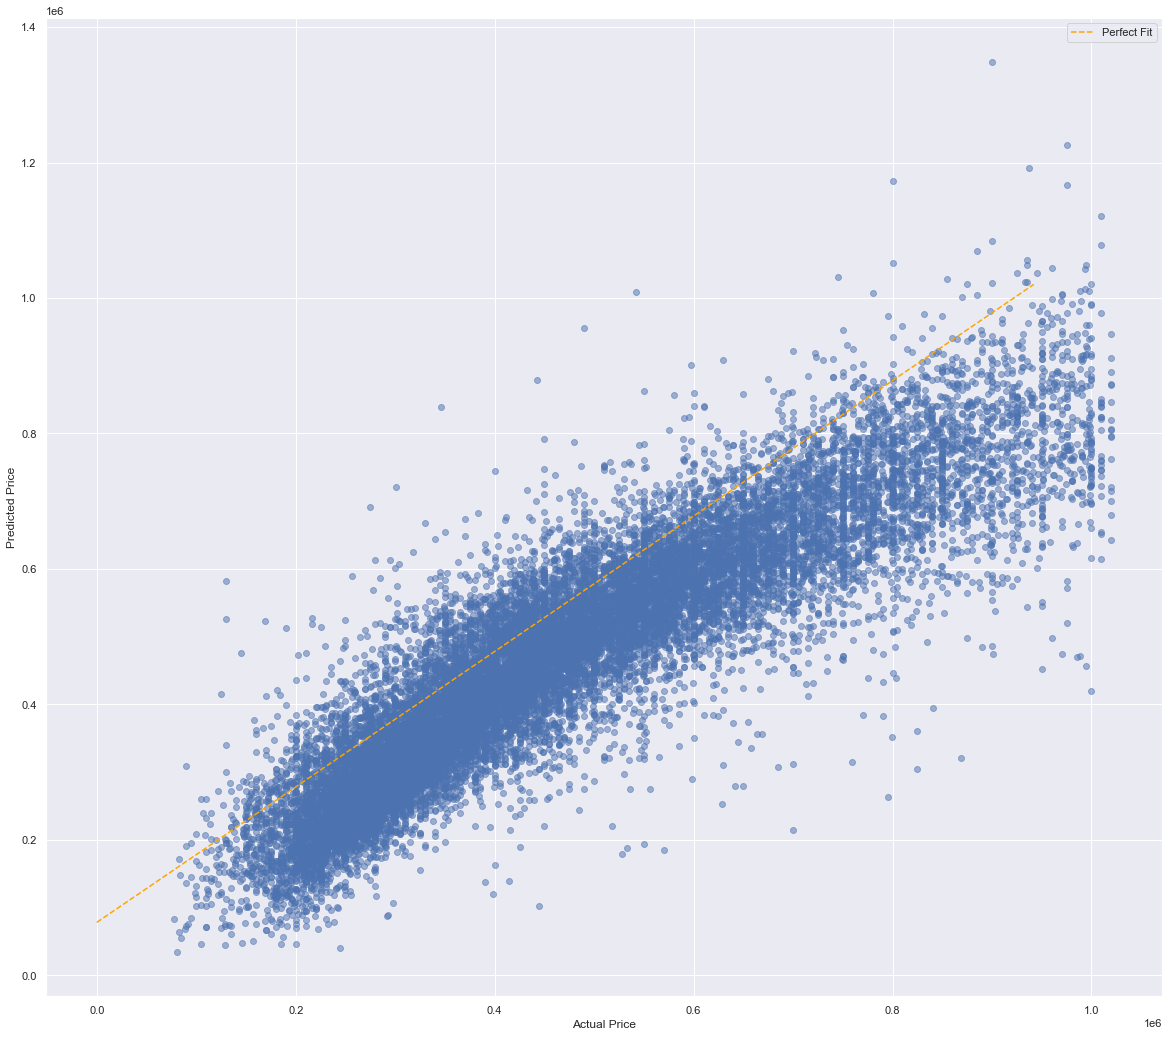

In [73]:
preds = lr.predict(X)
fig, ax = plt.subplots(figsize=(20, 18))

perfect_line = np.arange(y.min(), y.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y, preds, alpha=0.5)
# ax.set_facecolor("white")a
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

## looks like we have a linear relationship

### Investigating Normality

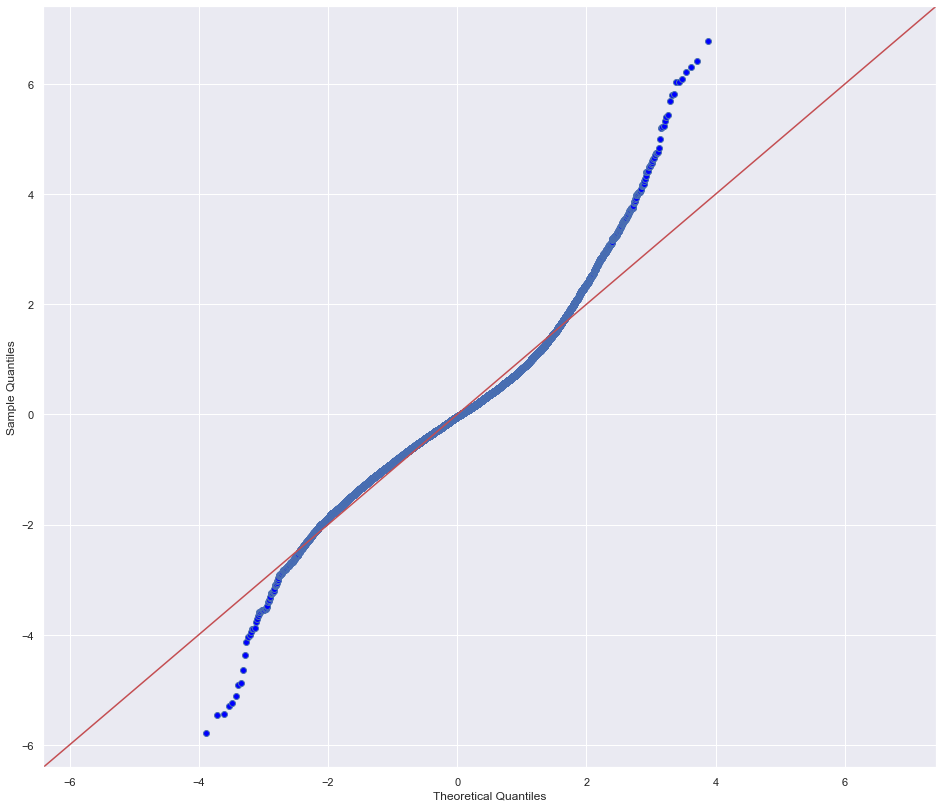

In [75]:
residuals = (y - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

## Outliers violating normality

###  Investigating Multicollinearity

In [93]:
## there is multicollinearity problem
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

pd.Series(vif, index=X.columns, name="Variance Inflation Factor")



index          4.2853
bedrooms      24.5681
bathrooms     28.2836
sqft_living   53.9660
sqft_lot       1.3615
                ...  
x0_98168       1.5560
x0_98177       1.1507
x0_98178       1.3667
x0_98188       1.3849
x0_98198       2.3291
Name: Variance Inflation Factor, Length: 68, dtype: float64

### Investigating Homoscedasticity

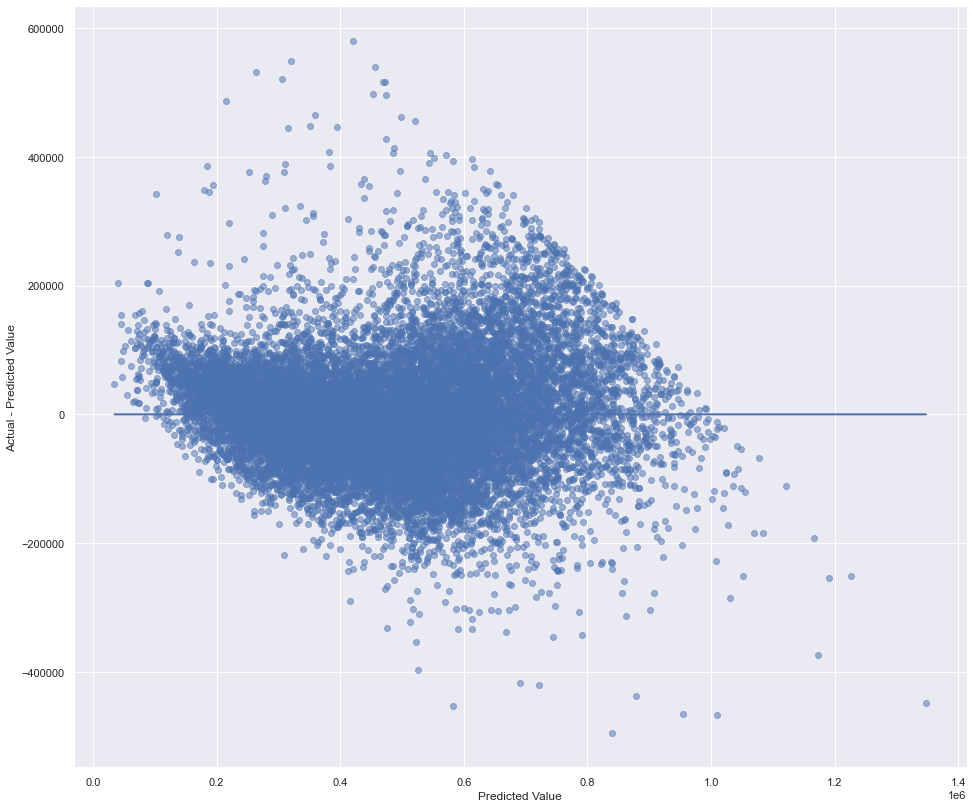

In [89]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

## violating homoscedasticity